The EDEX modelsounding plugin creates 64-level vertical profiles from GFS and ETA (NAM) BUFR products distirubted over NOAAport. Paramters which are requestable are **pressure**, **temperature**, **specHum**, **uComp**, **vComp**, **omega**, **cldCvr**.

In [23]:
from awips.dataaccess import DataAccessLayer
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("modelsounding")
forecastModel = "ETA"
request.addIdentifier("reportType", forecastModel)
request.setParameters("pressure","temperature","specHum","uComp","vComp","omega","cldCvr")

#availableLocs = DataAccessLayer.getAvailableLocationNames(request)
#availableLocs.sort()
request.setLocationNames("KDSM")

In [24]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastCycle(cycles[-1], times)
list(fcstRun)

[<DataTime instance: 2016-10-21 18:00:00 (0) >,
 <DataTime instance: 2016-10-21 18:00:00 (1) >,
 <DataTime instance: 2016-10-21 18:00:00 (2) >,
 <DataTime instance: 2016-10-21 18:00:00 (3) >,
 <DataTime instance: 2016-10-21 18:00:00 (4) >,
 <DataTime instance: 2016-10-21 18:00:00 (5) >,
 <DataTime instance: 2016-10-21 18:00:00 (6) >,
 <DataTime instance: 2016-10-21 18:00:00 (7) >,
 <DataTime instance: 2016-10-21 18:00:00 (8) >,
 <DataTime instance: 2016-10-21 18:00:00 (9) >,
 <DataTime instance: 2016-10-21 18:00:00 (10) >,
 <DataTime instance: 2016-10-21 18:00:00 (11) >,
 <DataTime instance: 2016-10-21 18:00:00 (12) >,
 <DataTime instance: 2016-10-21 18:00:00 (13) >,
 <DataTime instance: 2016-10-21 18:00:00 (14) >,
 <DataTime instance: 2016-10-21 18:00:00 (15) >,
 <DataTime instance: 2016-10-21 18:00:00 (16) >,
 <DataTime instance: 2016-10-21 18:00:00 (17) >,
 <DataTime instance: 2016-10-21 18:00:00 (18) >,
 <DataTime instance: 2016-10-21 18:00:00 (19) >,
 <DataTime instance: 2016-10-2

## Request data for a single time

In [25]:
response = DataAccessLayer.getGeometryData(request,[fcstRun[0]])

In [39]:
# initialize arrays
tmp,prs,sh,uc,vc,om,cld = [],[],[],[],[],[],[]

for ob in response:
    tmp.append(float(ob.getString(b"temperature")))
    prs.append(float(ob.getString(b"pressure")))
    sh.append(float(ob.getString(b"specHum")))
    uc.append(float(ob.getString(b"uComp")))
    vc.append(float(ob.getString(b"vComp")))
    om.append(float(ob.getString(b"omega")))
    cld.append(float(ob.getString(b"cldCvr")))

    
print("parms    = " + str(ob.getParameters()))
print("site     = " + str(ob.getLocationName()))
print("geom     = " + str(ob.getGeometry()))
print("datetime = " + str(ob.getDataTime()))
print("reftime  = " + str(ob.getDataTime().getRefTime()))
print("fcstHour = " + str(ob.getDataTime().getFcstTime()))
print("period   = " + str(ob.getDataTime().getValidPeriod()))
sounding_title = forecastModel + " "  + str(ob.getLocationName())  + "("+ str(ob.getGeometry())+")" + str(ob.getDataTime())

parms    = ['uComp', 'cldCvr', 'temperature', 'vComp', 'pressure', 'omega', 'specHum']
site     = KDSM
geom     = POINT (-93.68000030517578 41.52000045776367)
datetime = 1970-01-18 02:17:52.800000 (0)
reftime  = Jan 18 70 02:17:52 GMT
fcstHour = 0
period   = (Jan 18 70 02:17:52 , Jan 18 70 02:17:52 )


## Create data arrays and calculate dewpoint from spec. humidity

In [28]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import exp, log
import numpy as np

from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile, dewpoint
from metpy.calc import get_wind_speed,get_wind_dir, thermo, vapor_pressure
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

pres = np.array(prs)
# we can use units.* here...
t = (np.array(tmp)-273.16) * units.degC
p = np.array(pres)/100 * units.mbar
s = np.array(sh)

u,v = np.array(uc)*1.94384,np.array(vc)*1.94384 # m/s to knots
spd = get_wind_speed(u, v) * units.knots
dir = get_wind_dir(u, v) * units.deg


## Dewpoint from Specific Humidity

Because the modelsounding plugin does not return dewpoint values, we must calculate the profile ourselves.  Here are three examples of dewpoint calculated from specific humidity, including a manual calculation following NCEP AWIPS/NSHARP. 

### 1) metpy calculated mixing ratio and vapor pressure

In [29]:
rmix = (s/(1-s)) *1000 * units('g/kg')
e = vapor_pressure(p, rmix)
td = dewpoint(e)

### 2) metpy calculated assuming spec. humidity = mixing ratio

In [30]:
td2 = dewpoint(vapor_pressure(p, s))

### 3) NCEP AWIPS soundingrequest plugin
based on GEMPAK/NSHARP, from https://github.com/Unidata/awips2-ncep/blob/unidata_16.2.2/edex/gov.noaa.nws.ncep.edex.plugin.soundingrequest/src/gov/noaa/nws/ncep/edex/plugin/soundingrequest/handler/MergeSounding.java#L1783

In [31]:
# new arrays
ntmp,nprs,nsh = np.array(tmp)-273.16,np.array(prs),np.array(sh)

# where p=pressure(pa), T=temp(C), T0=reference temp(273.16)
rh = 0.263*nprs*nsh / (np.exp(17.67*ntmp/(ntmp+273.16-29.65)))
vaps =  6.112 * np.exp((17.67 * ntmp) / (ntmp + 243.5))
vapr = rh * vaps / 100
dwpc = np.array(243.5 * (np.log(6.112) - np.log(vapr)) / (np.log(vapr) - np.log(6.112) - 17.67)) * units.degC

/awips2/python/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/awips2/python/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


In [32]:
print min(td), max(td)
print min(td2), max(td2)
print min(dwpc), max(dwpc)

-88.7121665973 degC 4.83328438212 degC
-88.7122779647 degC 4.75580440789 degC
-88.7145460976 degC 4.87830433896 degC


## Plot with MetPy

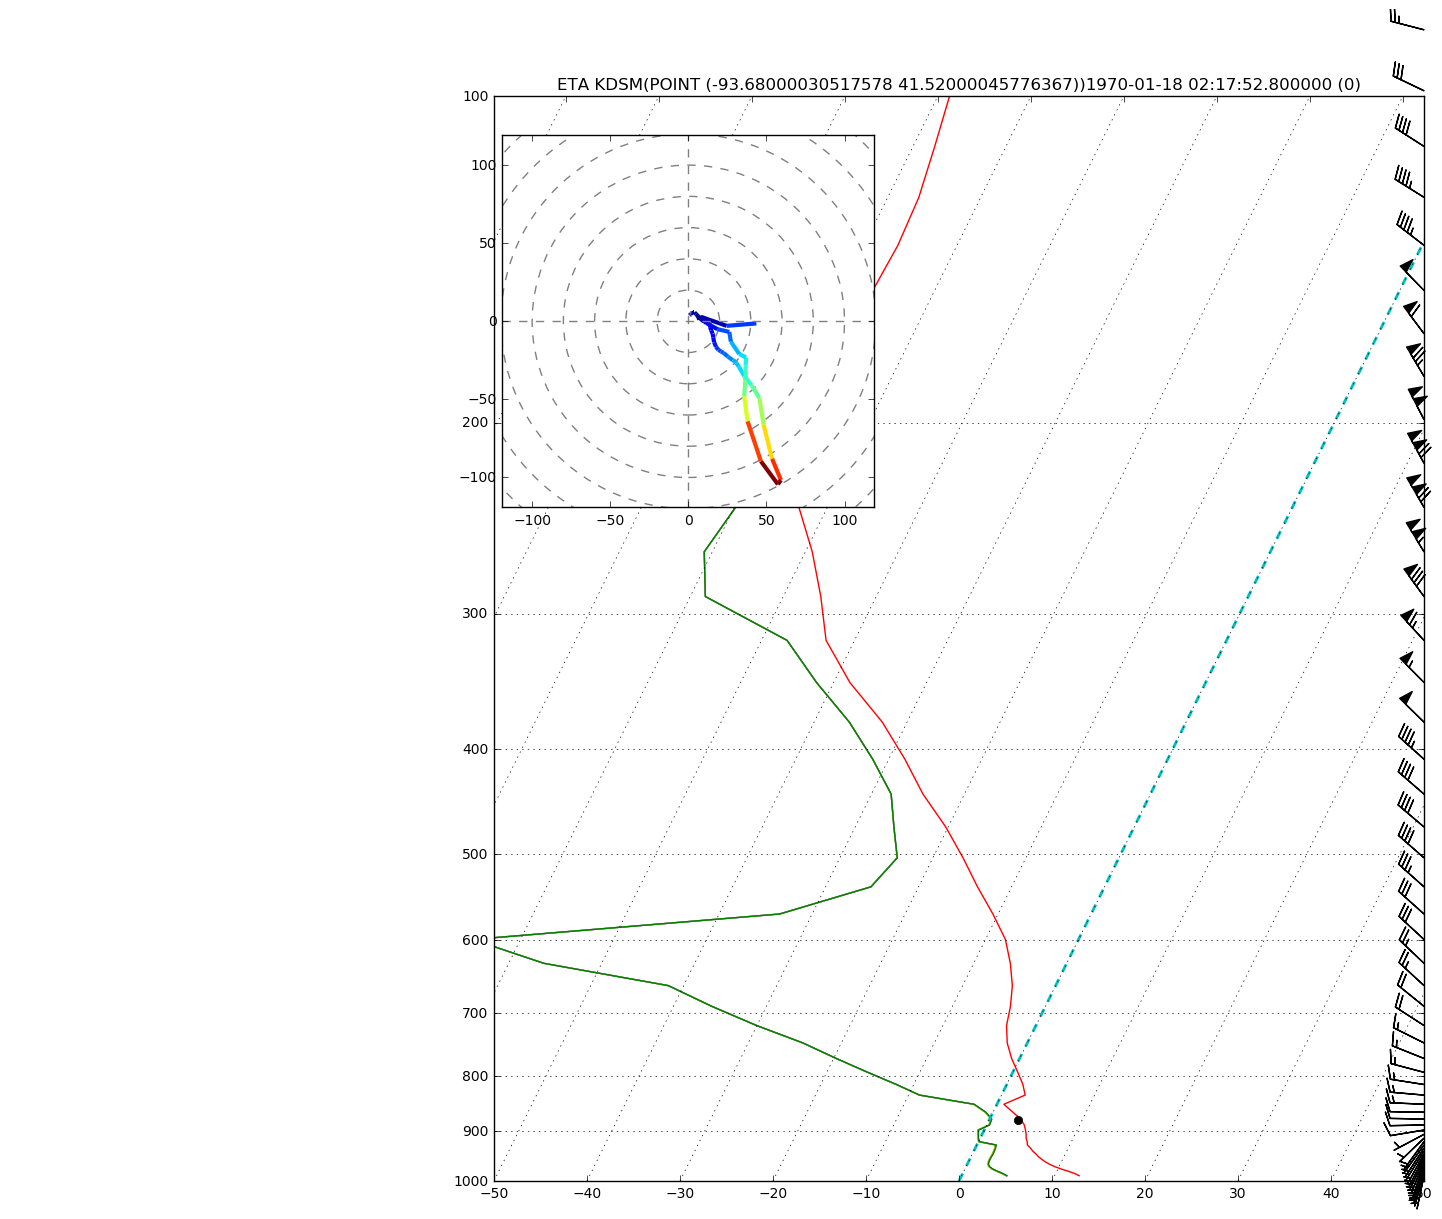

In [33]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 14)

# Create a skewT plot
skew = SkewT()

# Plot the data
skew.plot(p, t, 'r')
skew.plot(p, td, 'b')
skew.plot(p, td2, 'y')
skew.plot(p, dwpc, 'g')

skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)


plt.title(sounding_title)

# Calculate LCL height and plot as black dot
l = lcl(p[0], t[0], td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), t[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')


# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=get_wind_speed(u, v).max())
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()